## P-552- Hourly Energy Consumption Forecast
##### Business Objective: PJM Hourly Energy Consumption Data PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

##### The hourly power consumption data comes from PJM's website and are in megawatts (MW).

##### The regions have changed over the years so data may only appear for certain dates per region.

######• Split the last year into a test set- can you build a model to predict energy consumption? • Find trends in energy consumption around hours of the day, holidays, or long term trends? • Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends. • Forecast for next 30 days.

#### Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import itertools
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as tsa_plots
#from pmdarima.utils import c, diff

#### Read the dataset and do the EDA

In [2]:
df= pd.read_csv("PJMW_hourly.csv", header=0, index_col=0, parse_dates=True)

In [3]:
df.shape

(143206, 1)

In [4]:
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [5]:
df.tail()

,PJMW_MW
Datetime,
2018-01-01 20:00:00,8401.0
2018-01-01 21:00:00,8373.0
2018-01-01 22:00:00,8238.0
2018-01-01 23:00:00,7958.0
2018-01-02 00:00:00,7691.0


In [6]:
df.dtypes

,0
PJMW_MW,float64


In [7]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


###### We have the hourly energy consumption data with 143206 rows from 2002 to 2018.

In [8]:
df = df.sort_index()

###### Sorted the dataset to arrange it in ascending order

In [9]:
df.head()

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [10]:
df.tail()

,PJMW_MW
Datetime,
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0
2018-08-02 23:00:00,5892.0
2018-08-03 00:00:00,5489.0


###### After sorting we found out that the data is from April 2002 to August 2018

In [11]:
df[df.index.duplicated()]

,PJMW_MW
Datetime,
2014-11-02 02:00:00,4613.0
2015-11-01 02:00:00,3832.0
2016-11-06 02:00:00,4089.0
2017-11-05 02:00:00,4042.0


In [12]:
unique, counts = np.unique(df.index.duplicated(), return_counts=True)

In [13]:
dict(zip(unique, counts))

{np.False_: np.int64(143202), np.True_: np.int64(4)}

###### There are 4 Hours in the index that are duplicated in the data set

In [14]:
df.loc['2014-11-02'].head()

,PJMW_MW
Datetime,
2014-11-02 00:00:00,4912.0
2014-11-02 01:00:00,4805.0
2014-11-02 02:00:00,4571.0
2014-11-02 02:00:00,4613.0
2014-11-02 03:00:00,4619.0


In [15]:
df=df.groupby(level=0).mean()

In [16]:
df.loc['2014-11-02'].head()

,PJMW_MW
Datetime,
2014-11-02 00:00:00,4912.0
2014-11-02 01:00:00,4805.0
2014-11-02 02:00:00,4592.0
2014-11-02 03:00:00,4619.0
2014-11-02 04:00:00,4615.0


###### Replaced the duplicated indexes with the mean energy consumption values

In [17]:
pd.date_range(df.index.min(), df.index.max(), freq="y").difference(df.index)

/tmp/ipython-input-17-3318993286.py:1: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(df.index.min(), df.index.max(), freq="y").difference(df.index)


DatetimeIndex([], dtype='datetime64[ns]', freq='YE-DEC')

In [18]:
pd.date_range(df.index.min(), df.index.max(), freq="m").difference(df.index)

/tmp/ipython-input-18-1085082527.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(df.index.min(), df.index.max(), freq="m").difference(df.index)


DatetimeIndex([], dtype='datetime64[ns]', freq='ME')

In [19]:
pd.date_range(df.index.min(), df.index.max(), freq="d").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [20]:
pd.date_range(df.index.min(), df.index.max(), freq="H").difference(df.index)

/tmp/ipython-input-20-623889925.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(df.index.min(), df.index.max(), freq="H").difference(df.index)


DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

###### There are no missing years or date but there are 30 missing hours for the dataset. So we have deal with it.

In [21]:
df.loc['2002-04-07'].head()

,PJMW_MW
Datetime,
2002-04-07 00:00:00,5116.0
2002-04-07 01:00:00,5002.0
2002-04-07 02:00:00,4858.0
2002-04-07 04:00:00,4871.0
2002-04-07 05:00:00,4909.0


In [22]:
new_date_range = pd.date_range(df.index.min(), df.index.max(), freq="H")
df=df.reindex(new_date_range)
df.head(150)

/tmp/ipython-input-22-1681333260.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_date_range = pd.date_range(df.index.min(), df.index.max(), freq="H")


,PJMW_MW
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2002-04-07 02:00:00,4858.0
2002-04-07 03:00:00,NaN
2002-04-07 04:00:00,4871.0
2002-04-07 05:00:00,4909.0


In [23]:
df['PJMW_MW']=df.PJMW_MW.interpolate(method='linear')
df.head(150)

,PJMW_MW
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2002-04-07 02:00:00,4858.0
2002-04-07 03:00:00,4864.5
2002-04-07 04:00:00,4871.0
2002-04-07 05:00:00,4909.0


###### The missing hours are added and imputed with the mean of the above and below power consumption values

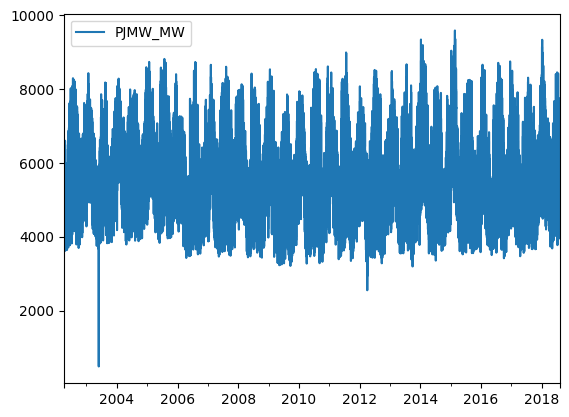

In [24]:
df.plot()
plt.show()

Though there is variation in the data ie, there is peak point as well as low points, there is no any specific trend. It looks like a stationary series with constatnt mean and sd.

array([[<Axes: title={'center': 'PJMW_MW'}>]], dtype=object)

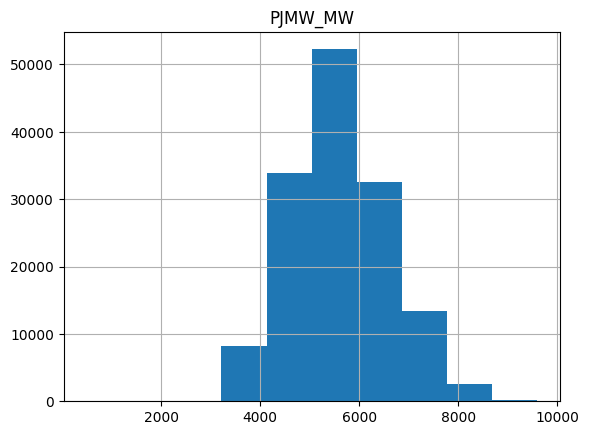

In [25]:
df.hist()

Plot the maximum,minimum and mean values of each year

/tmp/ipython-input-26-2092936780.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.PJMW_MW.resample(rule='A').mean().plot()


<Axes: >

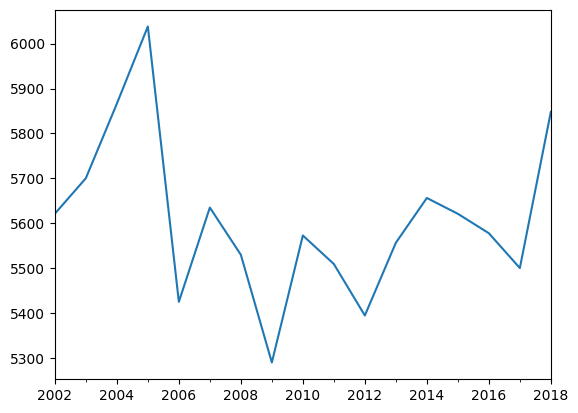

In [26]:
df.PJMW_MW.resample(rule='A').mean().plot()

/tmp/ipython-input-27-1321842475.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.PJMW_MW.resample(rule='A').max().plot()


<Axes: >

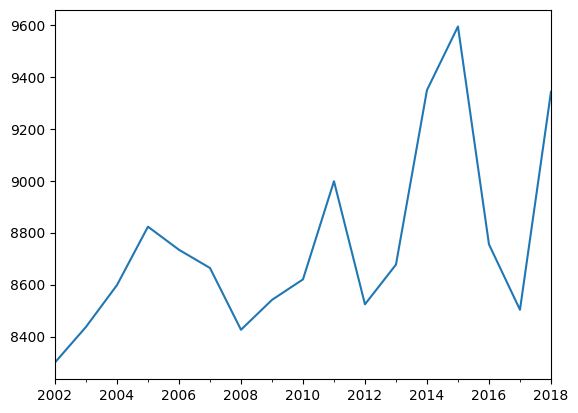

In [27]:
df.PJMW_MW.resample(rule='A').max().plot()

/tmp/ipython-input-28-2259194647.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.PJMW_MW.resample(rule='A').min().plot()


<Axes: >

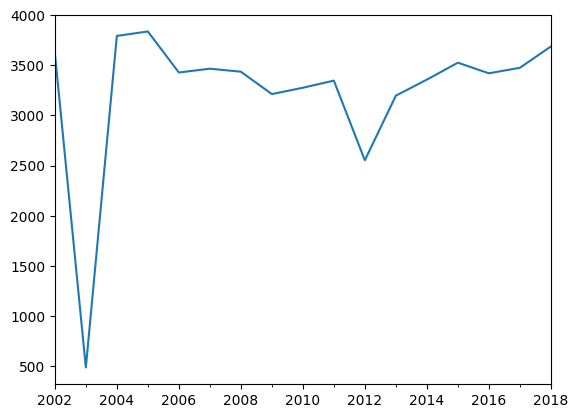

In [28]:
df.PJMW_MW.resample(rule='A').min().plot()

The minimum of 2003 seems to be an outlier.

In [29]:
df.loc['2003'].PJMW_MW.resample(rule='A').min()

/tmp/ipython-input-29-2146506234.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.loc['2003'].PJMW_MW.resample(rule='A').min()


,PJMW_MW
2003-12-31,487.0


In [30]:
df[df['PJMW_MW']==487.0]

,PJMW_MW
2003-05-29,487.0


In [31]:
df.loc['2003-05-29'].head()

,PJMW_MW
2003-05-29 00:00:00,487.0
2003-05-29 01:00:00,4560.0
2003-05-29 02:00:00,4424.0
2003-05-29 03:00:00,4351.0
2003-05-29 04:00:00,4337.0


In [32]:
df['PJMW_MW'].mask(df['PJMW_MW']<500,inplace=True)

/tmp/ipython-input-32-1259042600.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PJMW_MW'].mask(df['PJMW_MW']<500,inplace=True)


In [33]:
df['PJMW_MW']=df.PJMW_MW.interpolate(method='linear')

Replaced the outlier value with the linear interpolation method

In [34]:
df.loc['2003-05-29'].head()

,PJMW_MW
2003-05-29 00:00:00,4938.5
2003-05-29 01:00:00,4560.0
2003-05-29 02:00:00,4424.0
2003-05-29 03:00:00,4351.0
2003-05-29 04:00:00,4337.0


/tmp/ipython-input-35-2259194647.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.PJMW_MW.resample(rule='A').min().plot()


<Axes: >

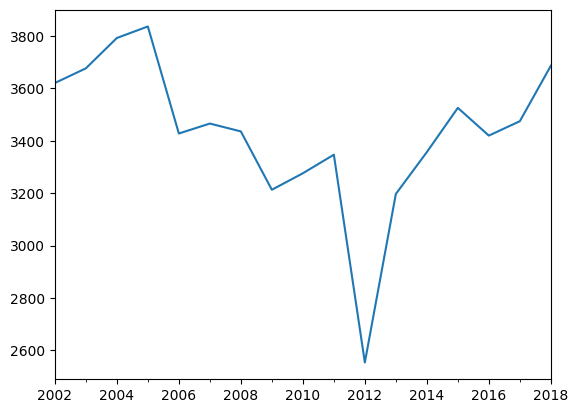

In [35]:
df.PJMW_MW.resample(rule='A').min().plot()

In [36]:
df[df['PJMW_MW']==2553.0]

,PJMW_MW
2012-04-02,2553.0


In [37]:
df.loc['2012-04-02'].head()

,PJMW_MW
2012-04-02 00:00:00,2553.0
2012-04-02 01:00:00,3904.0
2012-04-02 02:00:00,3779.0
2012-04-02 03:00:00,3776.0
2012-04-02 04:00:00,3764.0


In [38]:
df.to_csv('dataset.csv')

In [39]:
type(df)

pandas.core.frame.DataFrame

In [40]:
df1=df.copy()

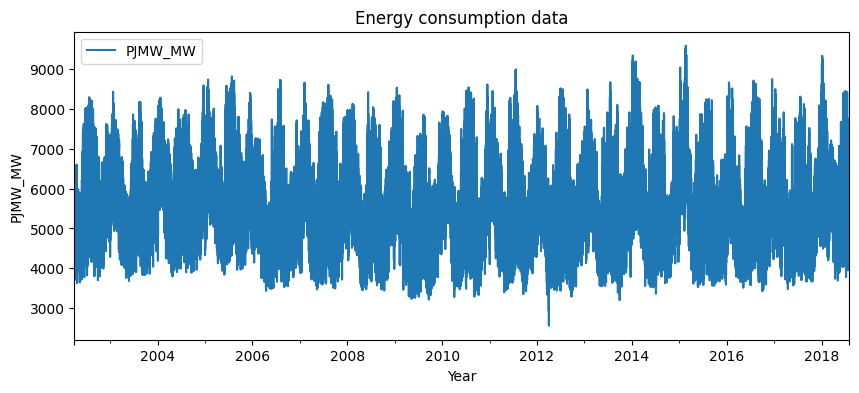

In [ ]:
plt.rcParams["figure.figsize"]= (10,4)
df1.plot()
plt.xlabel('Year')
plt.ylabel('PJMW_MW')
# displaying the title
plt.title("Energy consumption data")
plt.show()

In [41]:
df1

,PJMW_MW
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0
2018-08-02 23:00:00,5892.0


Extract the date,month,year, hour and weekname columns for further visualization

In [42]:
df1["Date"] = pd.to_datetime(df1.index,format='%Y-%m-%d %H:%M')

# Extracting Day, month name, year from the Datetime column using Date functions from pandas

df1["month"] = df1.Date.dt.strftime("%b") # month extraction
df1["year"] = df1.Date.dt.strftime("%Y") # year extraction
df1["day"] = df1.Date.dt.strftime("%d") # day extraction
df1["Hour"] = df1.Date.dt.strftime("%H") # Hour extraction

In [43]:
df1

,PJMW_MW,Date,month,year,day,Hour
2002-04-01 01:00:00,4374.0,2002-04-01 01:00:00,Apr,2002,01,01
2002-04-01 02:00:00,4306.0,2002-04-01 02:00:00,Apr,2002,01,02
2002-04-01 03:00:00,4322.0,2002-04-01 03:00:00,Apr,2002,01,03
2002-04-01 04:00:00,4359.0,2002-04-01 04:00:00,Apr,2002,01,04
2002-04-01 05:00:00,4436.0,2002-04-01 05:00:00,Apr,2002,01,05
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,2018-08-02 20:00:00,Aug,2018,02,20
2018-08-02 21:00:00,6496.0,2018-08-02 21:00:00,Aug,2018,02,21
2018-08-02 22:00:00,6325.0,2018-08-02 22:00:00,Aug,2018,02,22
2018-08-02 23:00:00,5892.0,2018-08-02 23:00:00,Aug,2018,02,23


In [44]:
df1.drop('Date',axis=1,inplace=True)

In [45]:
df1['weekday_name'] = pd.to_datetime(df1.index).day_name()

In [46]:
df1

,PJMW_MW,month,year,day,Hour,weekday_name
2002-04-01 01:00:00,4374.0,Apr,2002,01,01,Monday
2002-04-01 02:00:00,4306.0,Apr,2002,01,02,Monday
2002-04-01 03:00:00,4322.0,Apr,2002,01,03,Monday
2002-04-01 04:00:00,4359.0,Apr,2002,01,04,Monday
2002-04-01 05:00:00,4436.0,Apr,2002,01,05,Monday
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,Aug,2018,02,20,Thursday
2018-08-02 21:00:00,6496.0,Aug,2018,02,21,Thursday
2018-08-02 22:00:00,6325.0,Aug,2018,02,22,Thursday
2018-08-02 23:00:00,5892.0,Aug,2018,02,23,Thursday


In [47]:
df2=df1.copy()

In [48]:
df2.index.name= 'Datetime'

In [49]:
df2

,PJMW_MW,month,year,day,Hour,weekday_name
Datetime,,,,,,
2002-04-01 01:00:00,4374.0,Apr,2002,01,01,Monday
2002-04-01 02:00:00,4306.0,Apr,2002,01,02,Monday
2002-04-01 03:00:00,4322.0,Apr,2002,01,03,Monday
2002-04-01 04:00:00,4359.0,Apr,2002,01,04,Monday
2002-04-01 05:00:00,4436.0,Apr,2002,01,05,Monday
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,Aug,2018,02,20,Thursday
2018-08-02 21:00:00,6496.0,Aug,2018,02,21,Thursday
2018-08-02 22:00:00,6325.0,Aug,2018,02,22,Thursday


<Axes: >

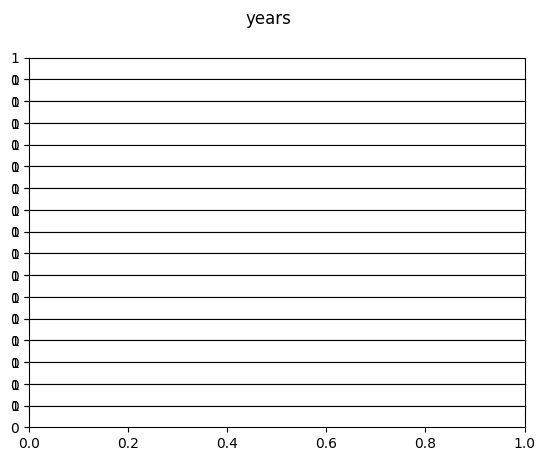

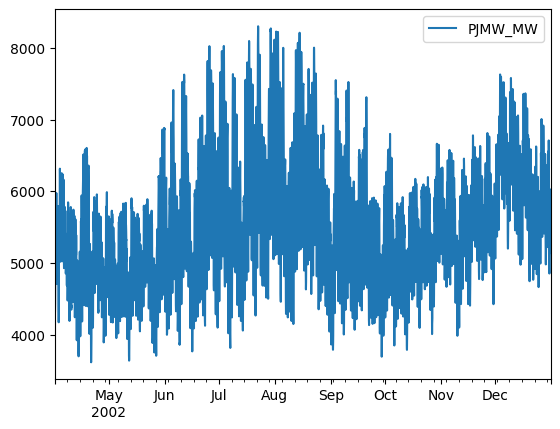

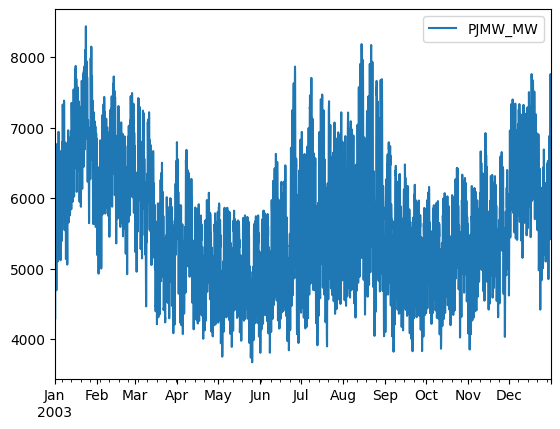

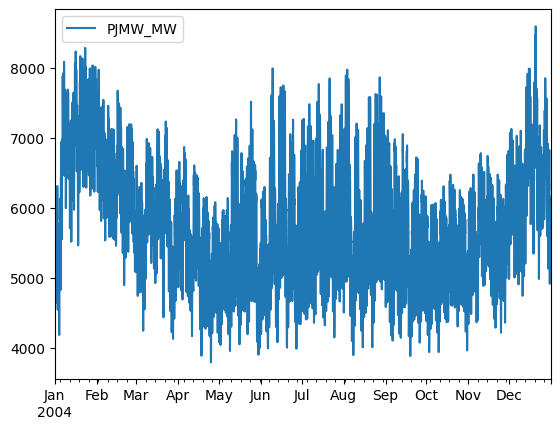

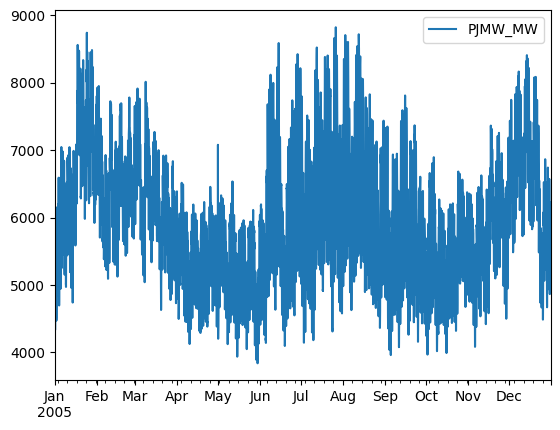

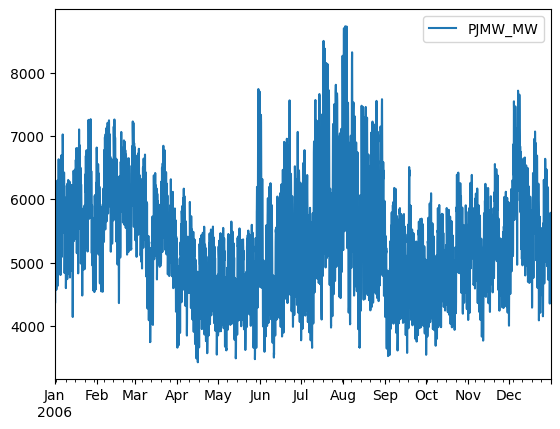

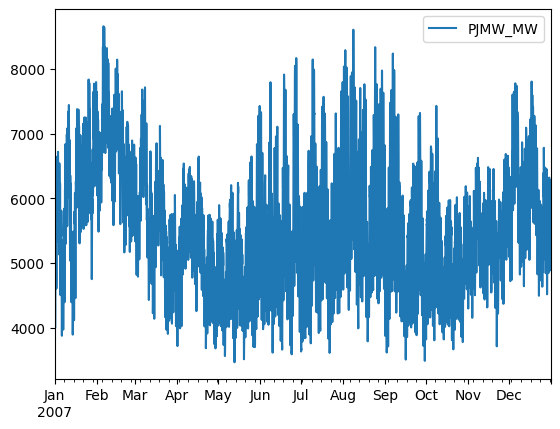

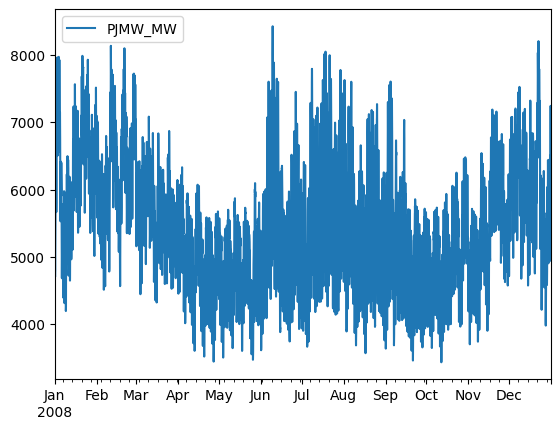

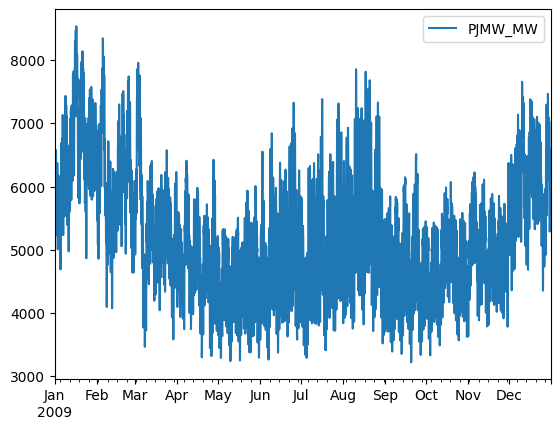

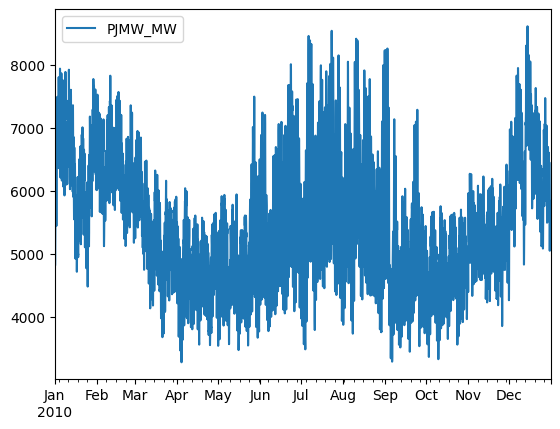

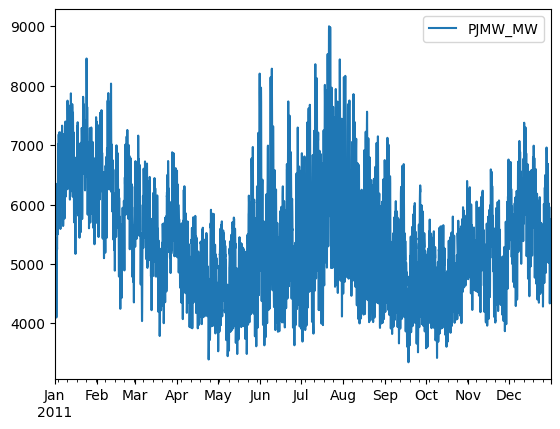

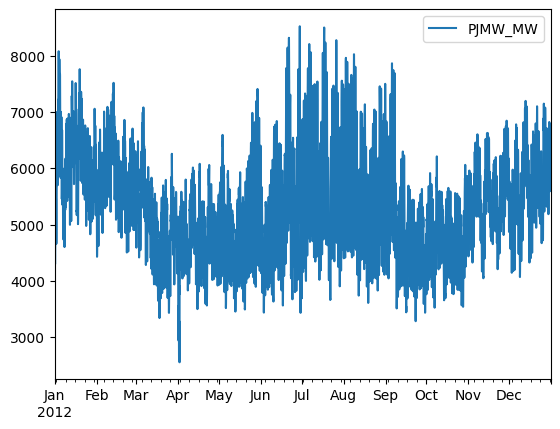

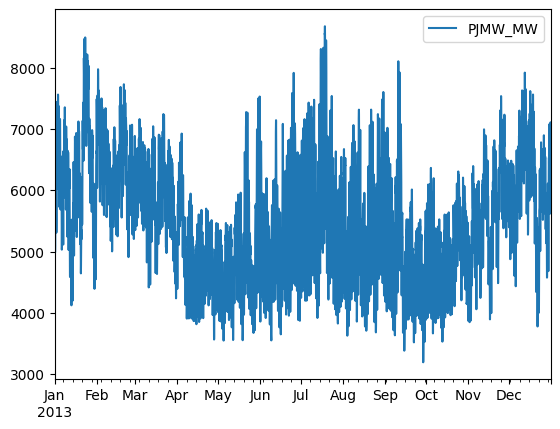

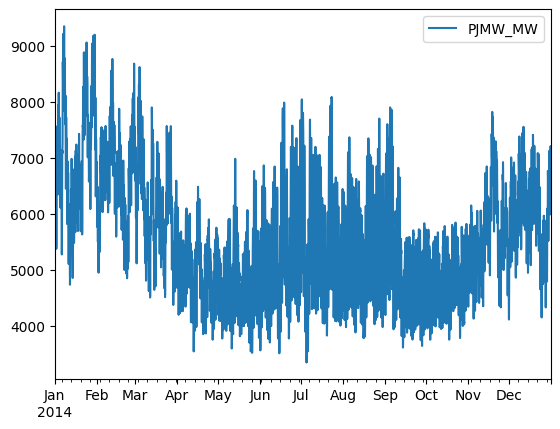

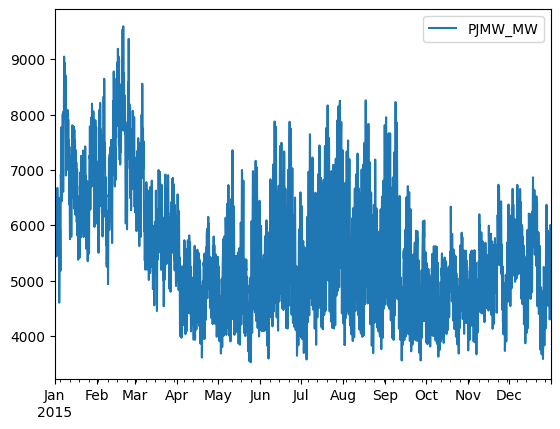

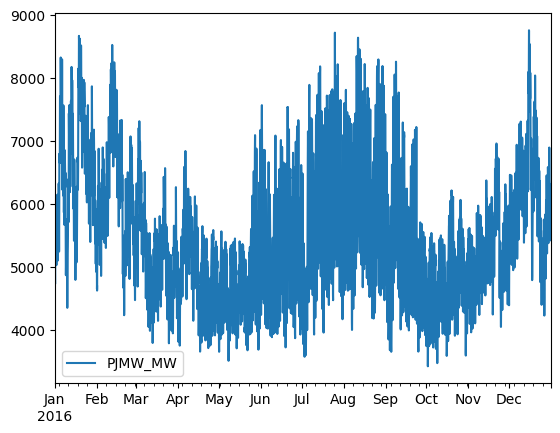

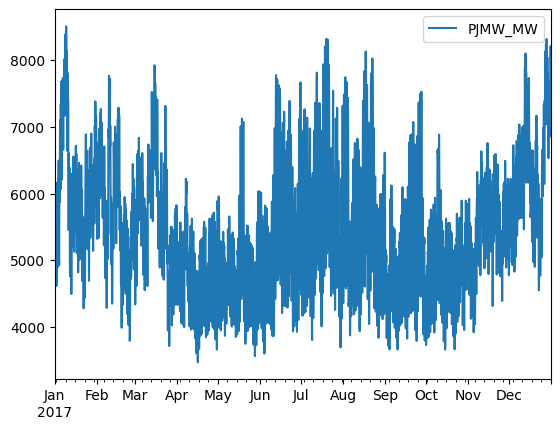

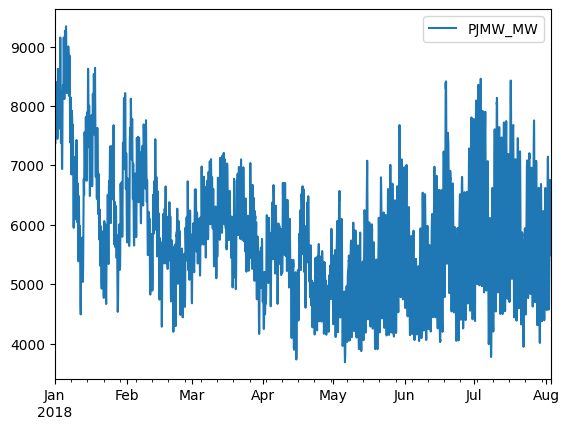

In [50]:
fig = plt.figure()
gs = fig.add_gridspec(17, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('years')
df.loc['2002'].plot()
df.loc['2003'].plot()
df.loc['2004'].plot()
df.loc['2005'].plot()
df.loc['2006'].plot()
df.loc['2007'].plot()
df.loc['2008'].plot()
df.loc['2009'].plot()
df.loc['2010'].plot()
df.loc['2011'].plot()
df.loc['2012'].plot()
df.loc['2013'].plot()
df.loc['2014'].plot()
df.loc['2015'].plot()
df.loc['2016'].plot()
df.loc['2017'].plot()
df.loc['2018'].plot()

In [51]:
df2.describe()

,PJMW_MW
count,143232.000000
mean,5602.245472
std,979.086063
min,2553.000000
25%,4906.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


Check for the yearly trend

Text(0.5, 1.0, 'Yearly trend')

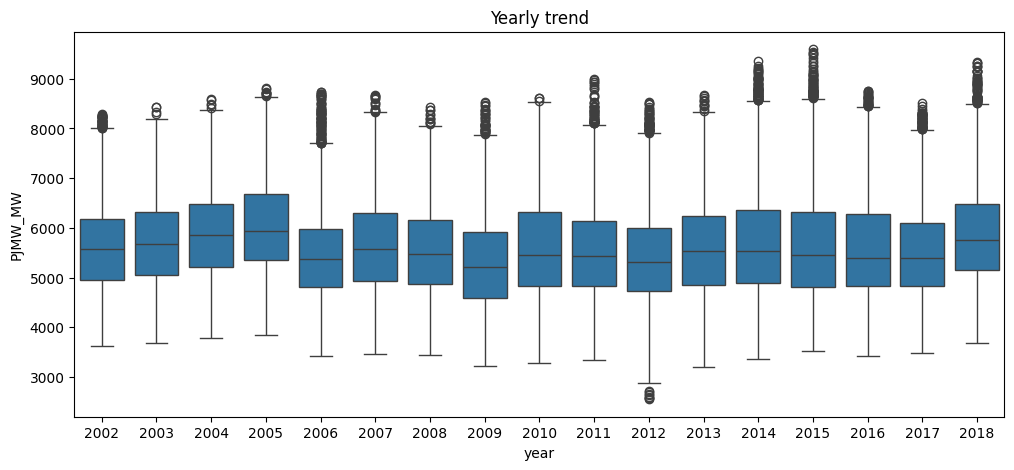

In [52]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.year,
                y = df2['PJMW_MW'],
                ax = ax)
ax.set_title('Yearly trend')

Observation: Low consumption in 2009 and high consumption in 2005

Check for the monthly trend

Text(0.5, 1.0, 'Monthly trend')

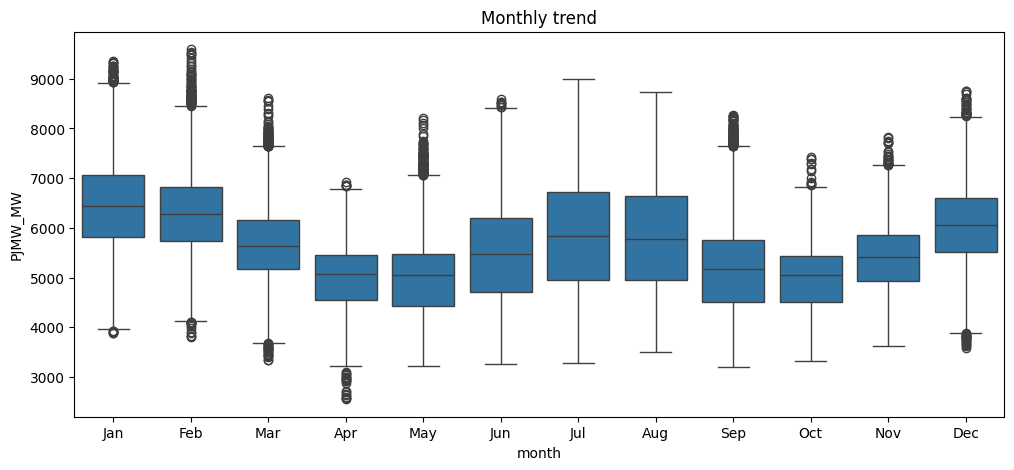

In [53]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.month,
                y = df2['PJMW_MW'], order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                ax = ax)
ax.set_title('Monthly trend')

In [54]:
df3=df2.copy()

Observation: For Dec, Jan, Feb and Jun,Jul, Aug the consumptin is higher as compared to other months.

Create the column 'Season' to Check for the seasonal trend

In [55]:
df3['season']=df3['month'].copy()

In [56]:
df3['season']=df3['season'].map({'Jan':'Winter','Feb':'Winter','Mar':'Winter','Apr':'Spring','May':'Spring','Jun':'Spring','Aug':'Summer','Sep':'Summer','Jul':'Summer','Oct': 'Fall','Nov': 'Fall','Dec': 'Fall'})

In [57]:
df3.head()

,PJMW_MW,month,year,day,Hour,weekday_name,season
Datetime,,,,,,,
2002-04-01 01:00:00,4374.0,Apr,2002,01,01,Monday,Spring
2002-04-01 02:00:00,4306.0,Apr,2002,01,02,Monday,Spring
2002-04-01 03:00:00,4322.0,Apr,2002,01,03,Monday,Spring
2002-04-01 04:00:00,4359.0,Apr,2002,01,04,Monday,Spring
2002-04-01 05:00:00,4436.0,Apr,2002,01,05,Monday,Spring


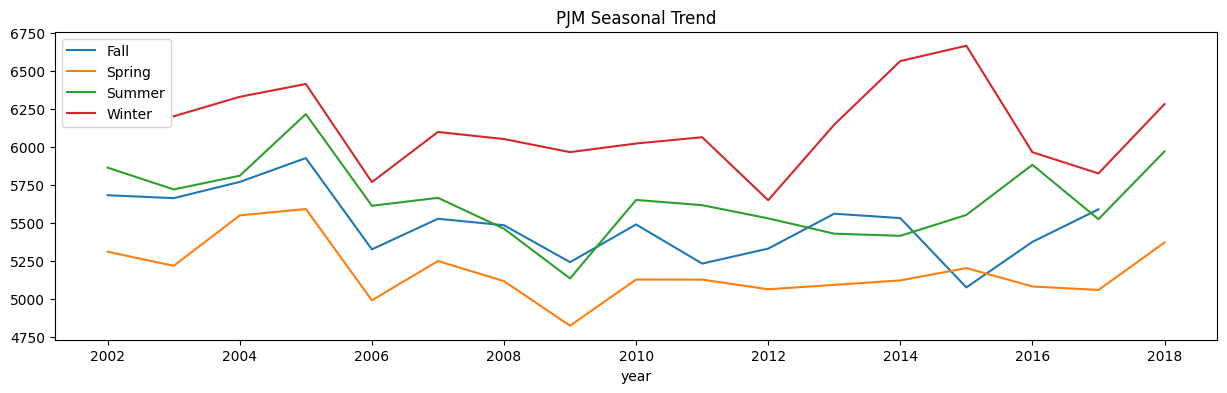

In [58]:
df3.pivot_table(index=df3['year'],
                     columns='season',
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM Seasonal Trend')
plt.legend(loc='upper left')

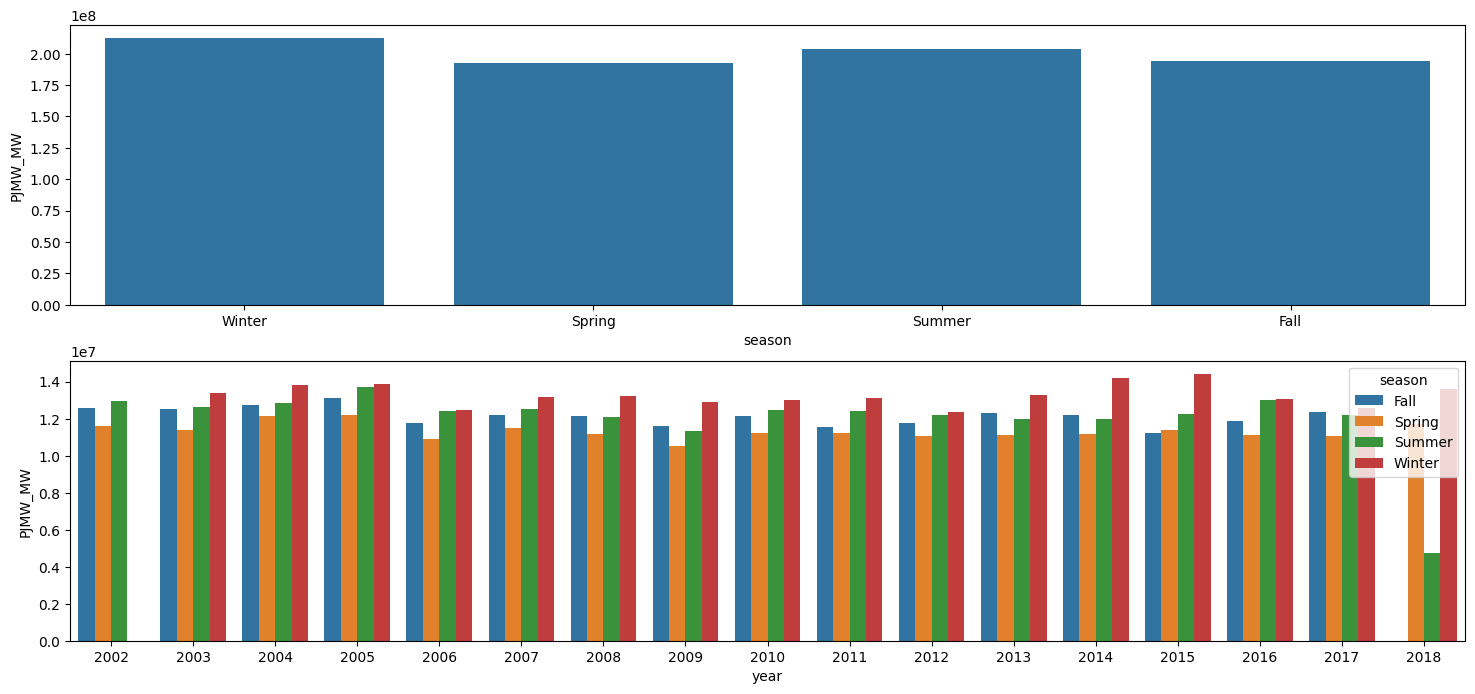

In [59]:
plt.figure(figsize=(18,8))
aux1 = df3[['season', 'PJMW_MW']].groupby( 'season' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='season', y='PJMW_MW', data=aux1, order=['Winter', 'Spring', 'Summer', 'Fall'] )

aux2 = df3[['year', 'season', 'PJMW_MW']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='season', data=aux2 );

Observation: For winter season the energy consumption is on a higher side and for spring the consumption is comparatively low

<Axes: xlabel='month', ylabel='year'>

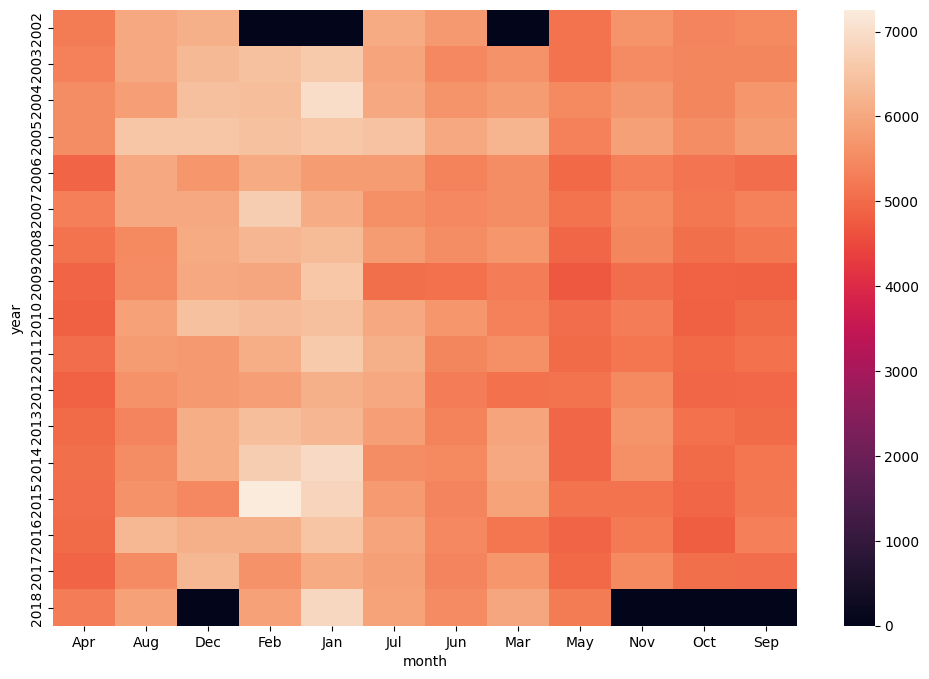

In [60]:
plt.figure(figsize=(12,8))
heatmap = pd.pivot_table(data=df2,values="PJMW_MW",index="year",columns="month",aggfunc="median",fill_value=0)
sns.heatmap(heatmap ,fmt="g")

Check for the hourly trend

Text(0.5, 1.0, 'Daily trend - Hourly basis')

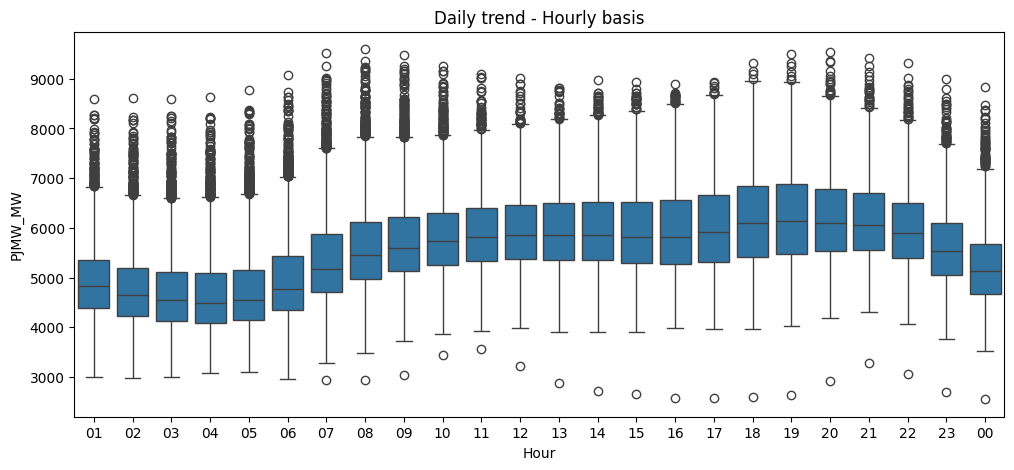

In [61]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.Hour,
                y = df2['PJMW_MW'],
                ax = ax)
ax.set_title('Daily trend - Hourly basis')

Observation: From midnight after 10 pm the power consumption starts decreasing and from morning 7 it increases till 10 pm.

Check for the daily trend

<Axes: xlabel='day', ylabel='PJMW_MW'>

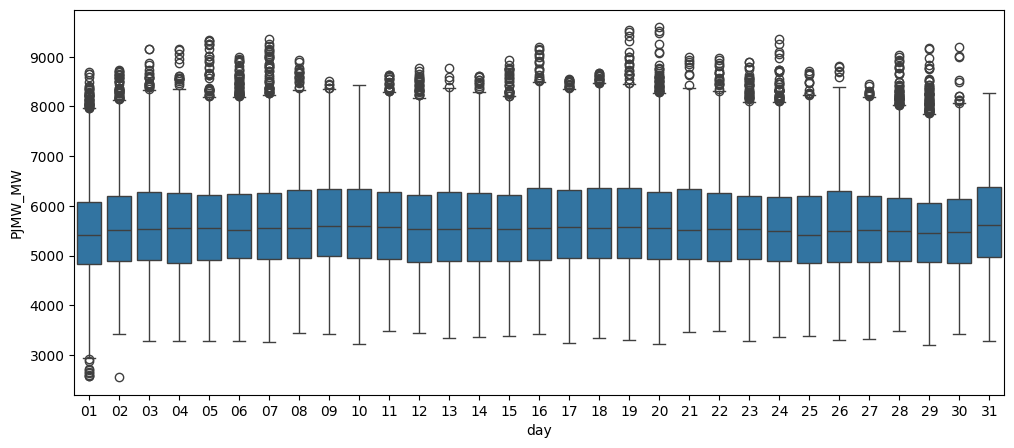

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.day,
                y = df2['PJMW_MW'],
                ax = ax)

Check for the Weekly trend

<Axes: xlabel='weekday_name', ylabel='PJMW_MW'>

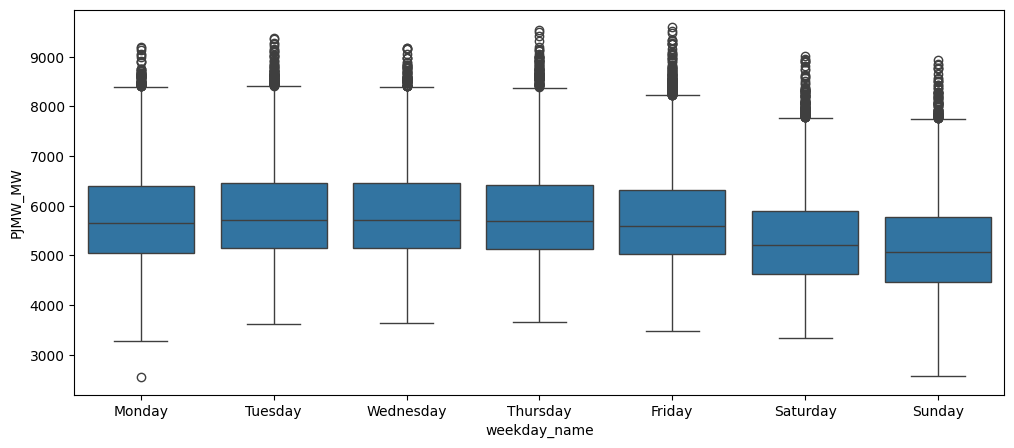

In [63]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df2.weekday_name,
                y = df2['PJMW_MW'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                ax = ax)

Observation:Low power consumption during Weekends

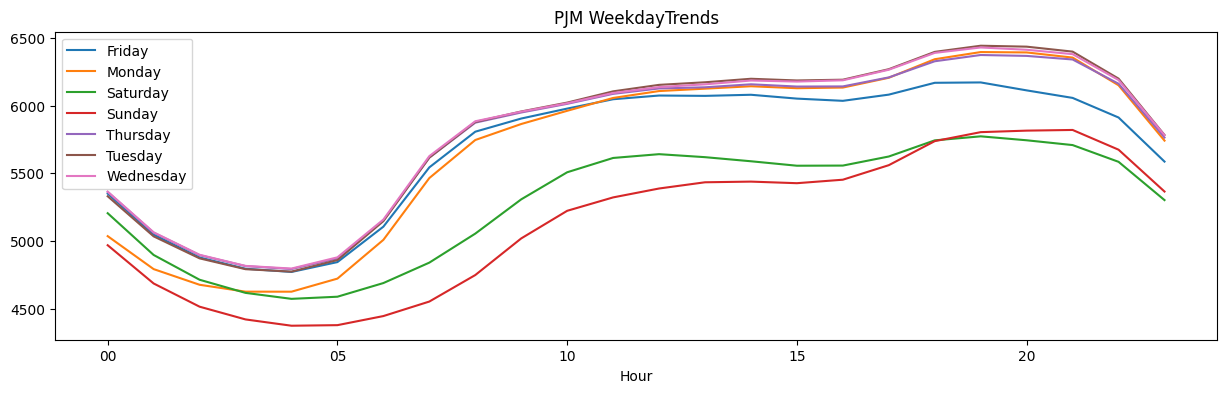

In [64]:
df2.pivot_table(index=df2['Hour'],
                     columns='weekday_name',
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM WeekdayTrends')
plt.legend(loc='upper left')

Observation: The plot shows that there are less consumption of power during weekends as compared to weekdays. Also the power consumption began to rise from morning 7 and at midnight 10 it again decreases.

In [65]:
df3['date'] = df3.index.date

In [66]:
df4=df3.reset_index()

Check for the Holiday trend

In [67]:
import holidays
df4['holidays'] = df4.date.apply( lambda x: 'Holiday' if x in holidays.US() else 'Normal day' )

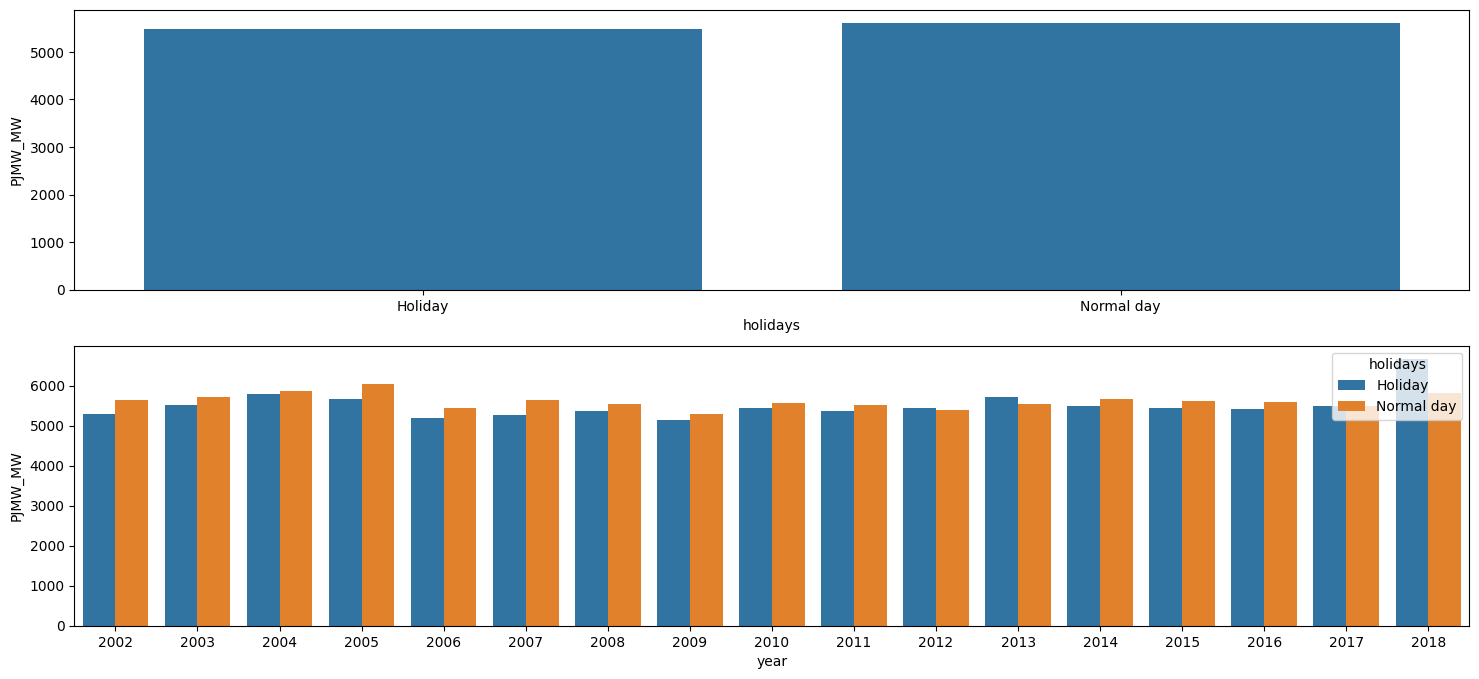

In [68]:
plt.figure(figsize=(18,8))

aux1 = df4[['holidays', 'PJMW_MW']].groupby( 'holidays' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='PJMW_MW', data=aux1 )

aux2 = df4[['year', 'holidays', 'PJMW_MW']].groupby( ['year', 'holidays'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='holidays', data=aux2 );

Decomposition

We will de-compose the time series into trend, seasonal and residuals

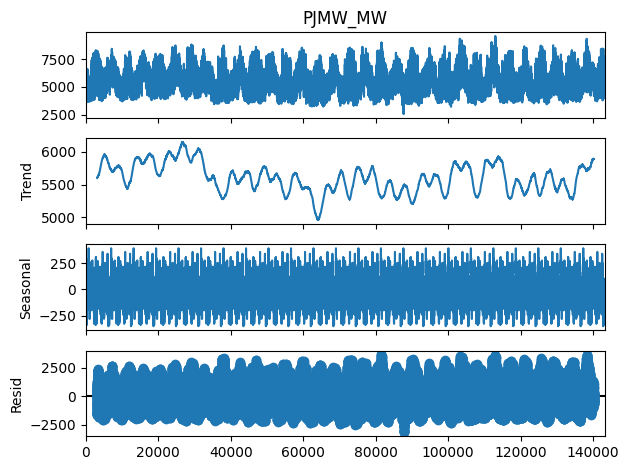

In [69]:
decompose = seasonal_decompose(df4.PJMW_MW,period=6205)
decompose.plot()
plt.show()

This graph gives us an overall trend in our data from year 2002 till year 2018. Seasonality cannot be checked as the datapoints are too many.

Lets resample and aggregate up to weekly level to reduce the noise

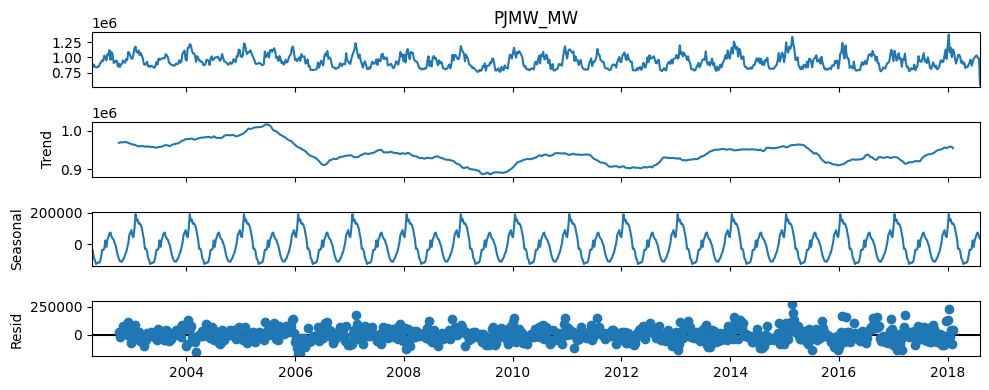

In [70]:
plt.rcParams["figure.figsize"]= (10,4)
weekly_data = df2.PJMW_MW.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level
fig = decomposition.plot()
plt.show()

Observations: There is no trend since its not increasing or decreasing. Seasonal pattern is consistent Resduals are whetever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform Ljung Box test to confirm if they are i.i.d as a group. We do not want to see any recognizable patterns in the residuals, e.g. waves, upward/downward slope, funnel pattern etc.

Ljung Box test

In [71]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df['PJMW_MW'], lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,136113.053316,0.0


Since lb_pvalue < 0.05, residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models. In this case, the residuals are uncorrelated.

LAG PLOT

A lag plot is used to help evaluate whether the values in a dataset or time series are random. If the data are random, the lag plot will exhibit no identifiable pattern. If the data are not random, the lag plot will demonstrate a clearly identifiable pattern

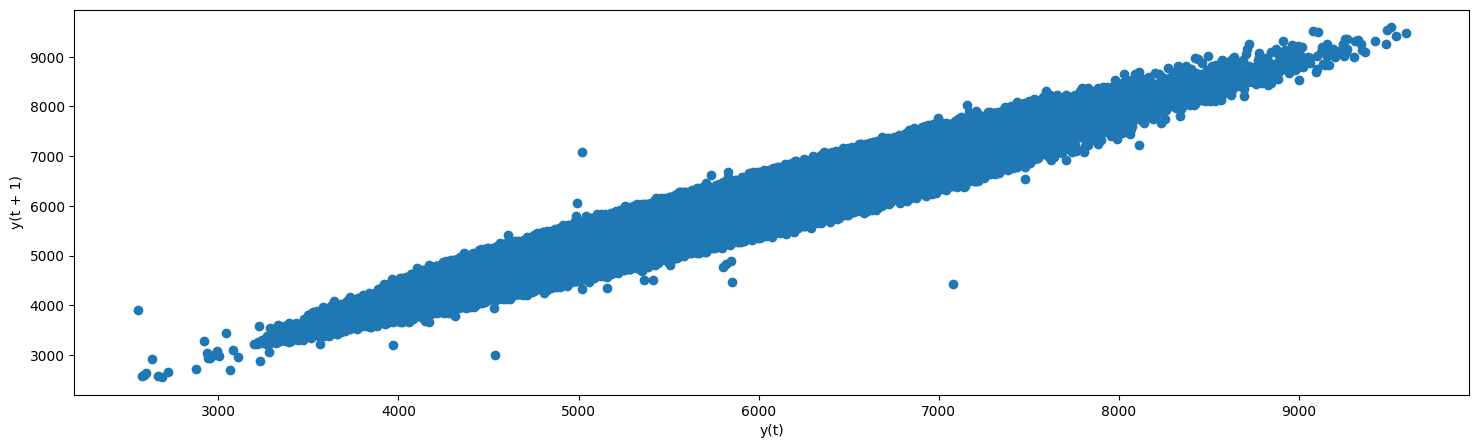

In [72]:
from pandas.plotting import lag_plot
plt.figure(figsize=(18,5))
lag_plot(df2.PJMW_MW)
plt.show()

Our data has Moderate Autocorrelation as the lag plot is in eliptical shape.

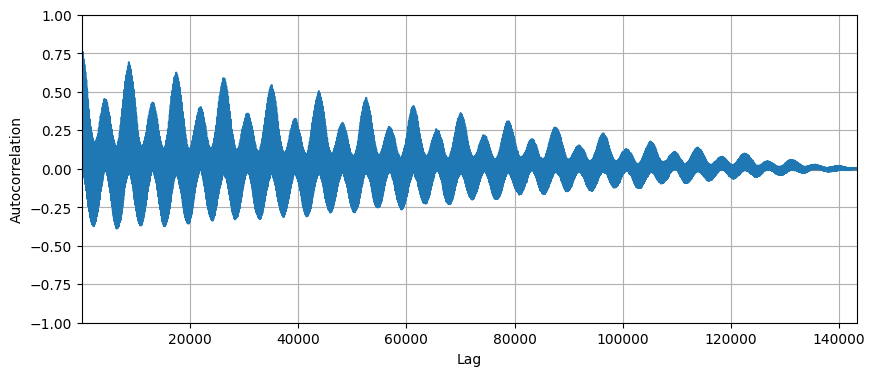

In [73]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df4.PJMW_MW)
plt.show()

Check for Stationarity

1.Constant mean

Mean is: 5602.245472380474


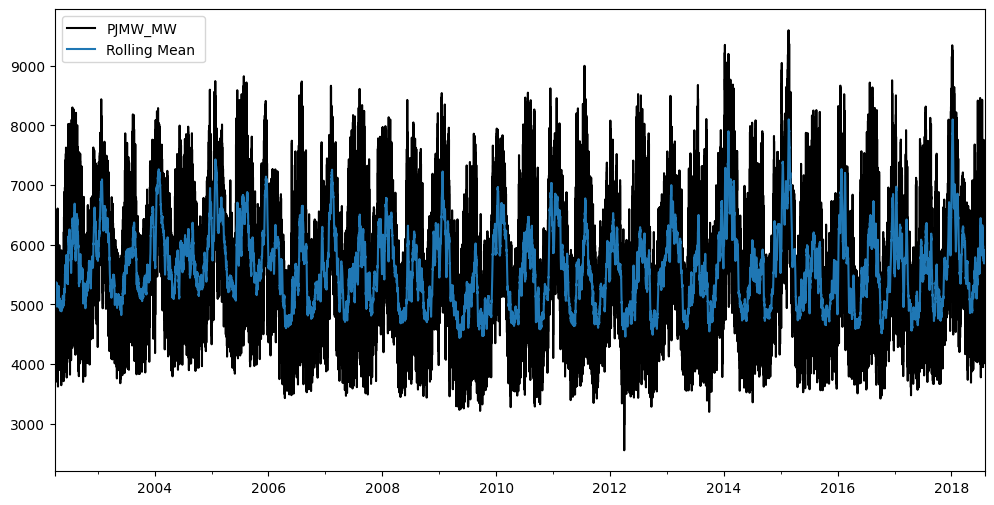

In [74]:
df.plot(figsize=(12,6), legend=True, label="Data", cmap='gray')
df["PJMW_MW"].rolling(200, center=False).mean().plot(legend=True, label="Rolling Mean ");
print("Mean is:", df["PJMW_MW"].mean())

2. constant variance

S.D is: 979.1


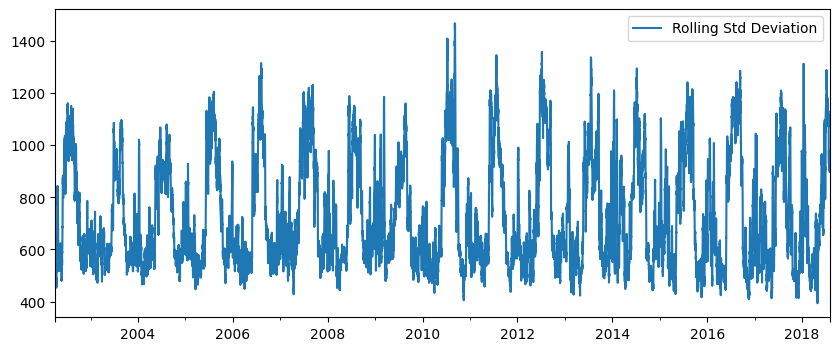

In [75]:
df["PJMW_MW"].rolling(200).std().plot(legend=True, label="Rolling Std Deviation");
print("S.D is:", round(df["PJMW_MW"].std(), 1))

Both mean and variance are constant.

Coefficient of Variation:

Coefficient of variation gives us an idea about the variability in the process.

c.v = s.d/mean

If C.V<0.75 => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3 => High Variability

In [76]:
cv = df["PJMW_MW"].std()/df["PJMW_MW"].mean()
cv.round(2)

np.float64(0.17)

CV < 0.75 Hence its a low variability process

Augmented Dickey-fuller test

In [77]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df4.PJMW_MW , autolag= 'AIC')
print("1. ADF :" , dftest[0])
print("2. P-Value :" , dftest[1])
print("3. Num of lags :" , dftest[2])
print("4. No of obs used for ADF regression and critical value calculation :" , dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t",key, ": " , val)

1. ADF : -19.9471042922947
2. P-Value : 0.0
3. Num of lags : 74
4. No of obs used for ADF regression and critical value calculation : 143157
5. Critical Values: 
	 1% :  -3.4303956800384174
	 5% :  -2.861560189928386
	 10% :  -2.5667807463806995


Our p-value is definitely less than 0.05 and so we can say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is stationary.

ACF & PACF Plot

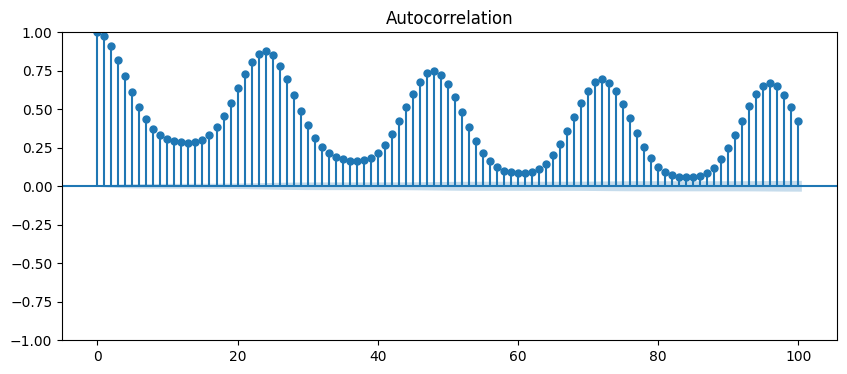

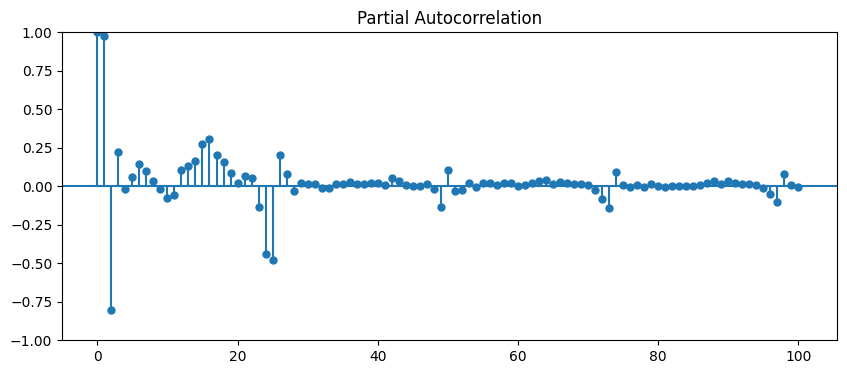

In [78]:
tsa_plots.plot_acf(df4.PJMW_MW,lags=100)
tsa_plots.plot_pacf(df4.PJMW_MW,lags=100)
plt.show()

Downsample data to daily basis

In [79]:
daily_data = df2['PJMW_MW'].resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [81]:
daily_data.head(5)

,PJMW_MW
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000


In [82]:
daily_data.to_csv('daily_data.csv')

Differencing the daily data to remove seasonality

/tmp/ipython-input-83-307956941.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=10)


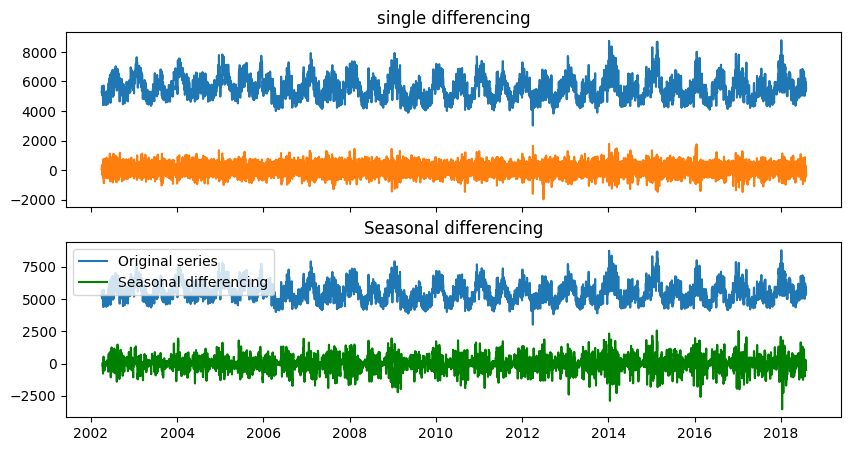

In [83]:
fig, axes = plt.subplots(2,1,figsize=(10,5),dpi=100,sharex=True)
data=daily_data
axes[0].plot(data[:], label = "Original series")
axes[0].plot(data[:].diff(1), label = "single differencing")
axes[0].set_title("single differencing")
plt.legend(loc='upper left', fontsize=10)

#Second differencing with 7 lags

axes[1].plot(data[:], label = "Original series")
axes[1].plot(data[:].diff(7), label = "Seasonal differencing",color='green')
axes[1].set_title("Seasonal differencing")
plt.legend(loc='upper left', fontsize=10)

plt.show()

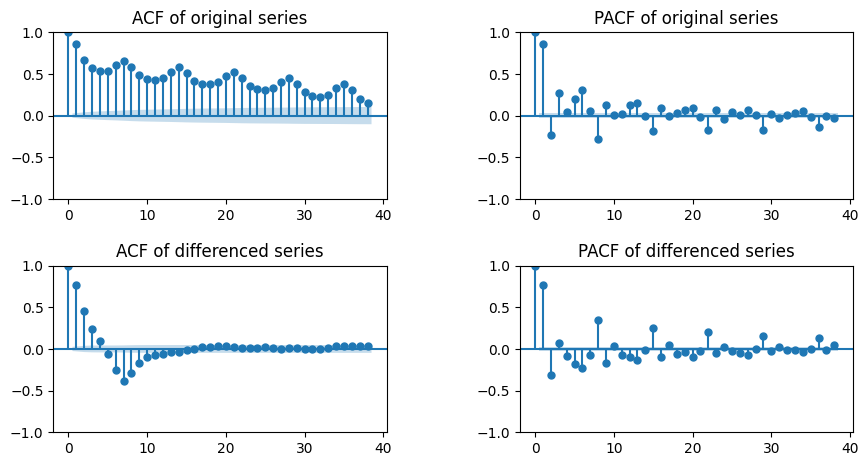

In [84]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

Double Differencing

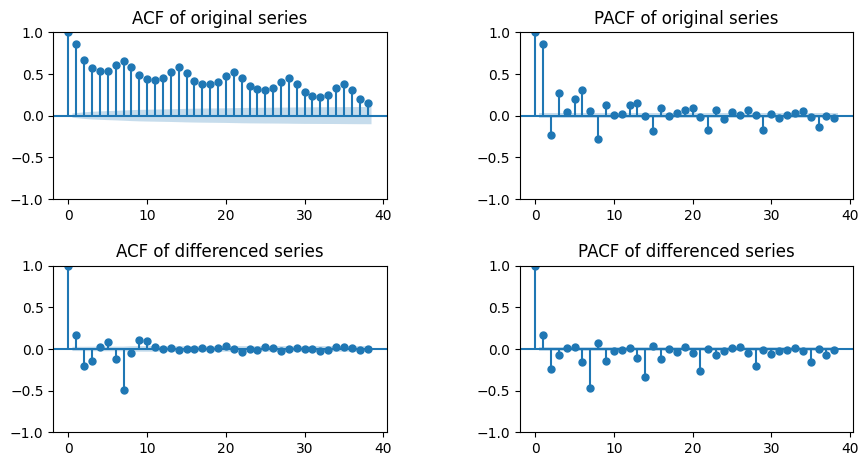

In [85]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle
# Initialize the scaler
scaler = StandardScaler()
# Fit and transform the target series
df['PJMW_MW_scaled'] = scaler.fit_transform(df[['PJMW_MW']])
# Save the scaler for inverse transform later
with open('scaler.pkl', 'wb') as f:
     pickle.dump(scaler, f)
# Preview standardized data
print(df[['PJMW_MW', 'PJMW_MW_scaled']].head())
# Now use df['PJMW_MW_scaled'] for ML model training

                     PJMW_MW  PJMW_MW_scaled
Datetime                                    
2002-12-31 01:00:00   5077.0       -0.536568
2002-12-31 02:00:00   4939.0       -0.677508
2002-12-31 03:00:00   4885.0       -0.732659
2002-12-31 04:00:00   4857.0       -0.761255
2002-12-31 05:00:00   4930.0       -0.686700
